# 2.0: Ill-posed problems and regularization - Shaw's problem

*Written by Andrew Valentine and Malcokm Sambridge.*

<!--<badge>--><a href="https://colab.research.google.com/github/msambridge/InversionPracticals/blob/main/Solutions/S2.0 - Ill-posed problmes and regularization-solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

When light passes through a thin slit it is diffracted. The 
distribution of light intensity as a function of incidence angle $\theta$ is represented by 
$m(\theta)$. After passing through the slit it becomes $d(\phi)$, where $\phi$ is the angle as defined in the 
figure.

<img src="../Figures/shaw.png" alt="Diffraction of a light beam passing through a thin slit." width="300"/>



The intensity before, $m(\theta)$, and after, $d(\phi)$, passing through the slit and  are related by the expression


$$
d(\phi) = \int_{-\pi/2}^{\pi/2} (\cos(\phi) + \cos(\theta))^2 \left( 
{\sin(\pi(\sin(\phi) + \sin(\theta)))\over\pi(\sin(\phi) + \sin(\theta))}
\right)^2m(\theta)d\theta
$$


Here the data are measured intensity $d(\phi)$ at N equal intervals, 

$$d(\phi_i) = d_i, (i=1,\dots,N)$$

where $- \frac{\pi}{2} <= \phi_i <= \frac{\pi}{2}$, and the model is the incident intensity $m(\theta)$ discretized over the same angular intervals, 

$$m(\theta_j) = m_j, (j=1,\dots,N).$$

This leads to a discrete linear system of $N\times N$ equations, ${\bf d} = G {\bf m}$, where

$$
G_{i,j} = \Delta \phi (\cos(\phi_i) + \cos(\theta_j))^2 \left( 
{\sin(\pi(\sin(\phi_i) + \sin(\theta_j)))\over\pi(\sin(\phi_i) + \sin(\theta_j))}
\right)^2
$$

As we shall see, the resulting inverse problems is severely ill-posed. Routine `G,m,d=shaw(20)` computes the G matrix along with a sample model and data for this problem with $N=20$. 


#### Reference
C. B. Shaw, Jr., "Improvements of the resolution of an instrument by numerical solution of an integral equation", *J. Math. Anal. Appl.* 37 (1972), 83-112. 

----------

First load some libraries.

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !git clone https://github.com/msambridge/InversionPracticals
# %cd InversionPracticals

In [4]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import sys
sys.path.append("../software")
import plotcovellipse as pc
from shaw import shaw, pseudo_inverse

In [5]:
n = 18      # number of points to discretize the model and data functions
G = shaw(n) # Calculate the G matrix for this discretization

Here we defne a simple test model $m(\theta)$ consisting of a single spike.

In [6]:
spikemodel = np.zeros(n)
spikecentre = int(n/2)                              # location of spike
spikemodel[spikecentre] = 1.                        # amplitude of spike model
spikeangles = -np.pi/2+np.arange(.5,n+.5,1)*np.pi/n # angles of input 

And now lets plot the test model.

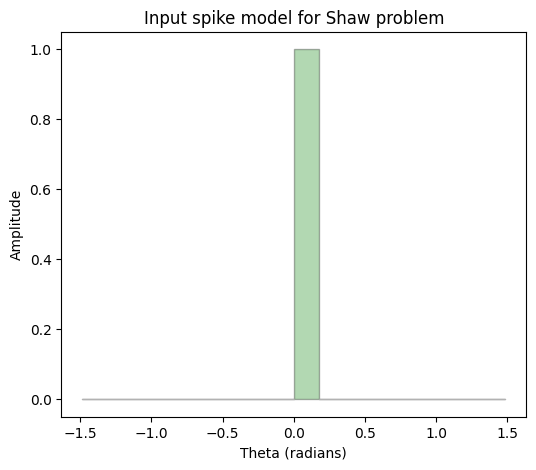

In [7]:
fig, ax = plt.subplots(figsize=(6,5))
plt.fill_between(spikeangles, spikemodel,step='mid',alpha=0.3,color='green',edgecolor='k')
plt.title('Input spike model for Shaw problem')
plt.xlabel('Theta (radians)')
plt.ylabel('Amplitude')
plt.show()

Now lets calculate the corresponding data for the spike test model for each angle, $d(\phi)$, and plot it.

In [8]:
spikedata = np.dot(G,spikemodel)

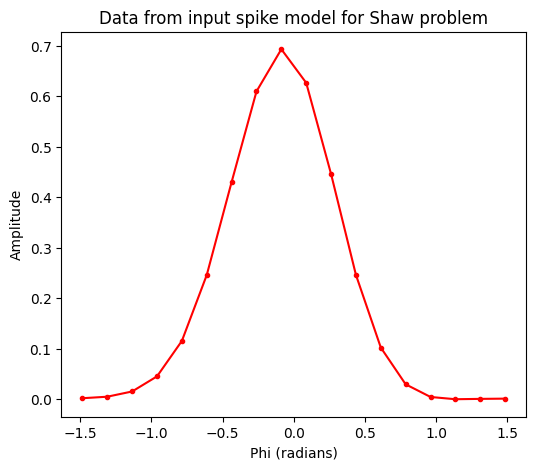

In [9]:
fig, ax = plt.subplots(figsize=(6,5))
plt.plot(spikeangles,spikedata,'r.-',label='Spike data')
plt.title('Data from input spike model for Shaw problem')
plt.xlabel('Phi (radians)')
plt.ylabel('Amplitude')
plt.show()

In [10]:
def LSsolver(y,G,Cdinv=None):
    if(Cdinv==None): Cdinv = np.eye(len(y))
    A = np.dot(np.transpose(G), Cdinv)
    GtG = np.dot(A, G) # G^T C_inv G^T
    GtGinv = np.linalg.inv(GtG) # Inverse of G^TC_inv G
    B = np.dot(A,y)
    mls = np.dot(GtGinv, B) # Least squares solution 
    return mls

**Task 1** Calcuate the Least squares solution and plot it. For this dataset the true solution is the test spike model. How does this solution compare in terms of amplitude and shape?

In [20]:
sol = LSsolver(spikedata,G)

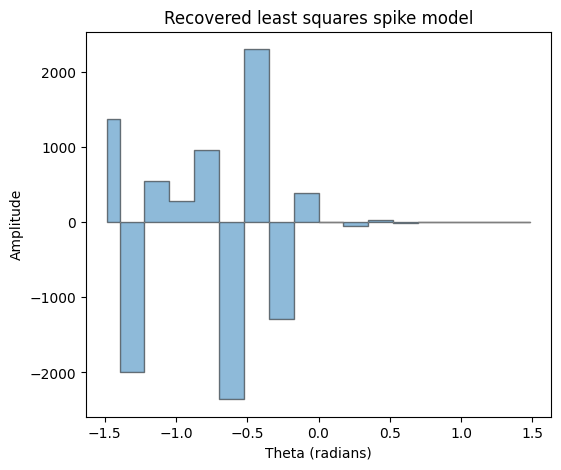

In [21]:
fig, ax = plt.subplots(figsize=(6,5))
plt.fill_between(spikeangles, sol,step='mid',alpha=0.5,edgecolor='k')
plt.title('Recovered least squares spike model')
plt.xlabel('Theta (radians)')
plt.ylabel('Amplitude')
plt.show()

*Clearly very poor, with very large amplitudes*.

### Singular value decomposition

Any matrix $N\times M$ matrix $G$ can be written in terms of its singular value decomposition. 

$$
G = U S V^T,
$$
where 

$V$ is the $M\times M$ matrix of orthogonal singular vectors spanning the model parameter space;

$U$ is the $N\times N$ matrix of orthogonal singular vectors spanning the data space;

and $S_p$ is the $M\times N$ matrix with all zeros except the $p$ singular values of $G$ along its first diagonal.

If $p$ is the rank of the matrix $G$, then this immediately reduces to 
$$
G = U_p S_p V_p^T,
$$
where $U_p$ is the $N\times p$ matrix formed by taking the first $p$ columns of $U$; $V_p$ is the $M\times p$ matrix formed by taking the first $p$ columns of $V$; and $S_p$ is the diagonal $p\times p$ matrix of singular values, $s_i, (i=1,\dots,p)$ of the matrix $G$.

In python, the command `U,s,Vt = np.linalg.svd(G)` will calculate the singular vectors as matrices $(U,V)$ and singular values . (Here Vt is the transpose of V.) 

**Task 2** Calculate the singular values of the $G$ matrix. Plot singular values $s_i$ as a function of index $i$ on a semi-log plot using `plt.semilogy()`. What do you notice about the shape ?

In [22]:
U,s,Vt = np.linalg.svd(G) # singular value decomposition 

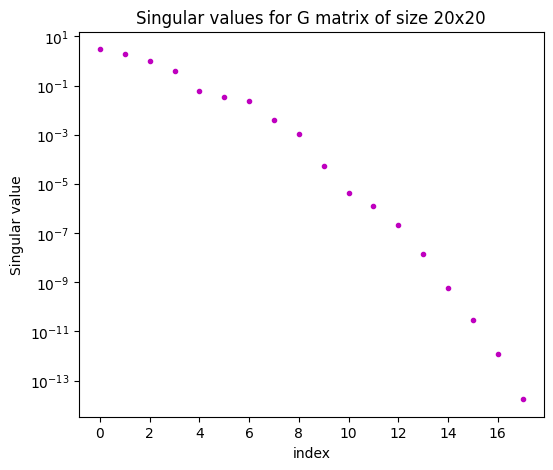

In [23]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(figsize=(6,5))
plt.semilogy(s,'m.')
plt.title('Singular values for G matrix of size '+repr(20)+'x'+repr(20))
plt.xlabel('index')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('Singular value')
plt.show()

*Singular values decrease rapidly with index.*

**Task 3** Calculate the rank and condition number of $G$.

Hint: numpy has a routine for this, `np.linalg.matrix_rank(A)` gives the rank of the matrix A; while
`np.linalg.cond(A)` gives it conidtion number.

What do these terms mean ? How do these terms depend on the singular values, $s$ ? 

In [15]:
rank = np.linalg.matrix_rank(G)
cond = np.linalg.cond(G)
# tol = G.max()*n*sys.float_info.epsilon
tol = 1.0E-14
count = np.sum(s > tol) # number of non zero singular values
ratio = np.max(s)/np.min(s) # ratio of largest to smallest non-zero singular values
print(' Rank of G matrix: ',rank,'\n Number of singular values > tol: ',count)
print(' Condition number of G matrix: ',cond,'\n Ratio of largest to smallest singular value',ratio)

 Rank of G matrix:  18 
 Number of singular values > tol:  18
 Condition number of G matrix:  169749820766367.28 
 Ratio of largest to smallest singular value 169749820766367.25


*The rank of $G$ is the number of non-zero singular values of $G$. The condition number is the ratio of the highest to the lowest singular values $=s_1/s_p$.*

#### The pseudo inverse of $G$

The pseudo inverse solution of ${\mathbf d} = G {\mathbf m}$ is given by 
$$
{\mathbf m}^{\dagger} = G^{\dagger}{\mathbf d},
$$
where $G^{\dagger}$ is the pseudo inverse of the matrix $G$
$$
G^{\dagger} = V_p S_p^{-1} U_p^T,
$$

For the Shaw problem the discretization of data and model functions is the same and so $M=N$. For convenience the routine `Gdagger = pseudo_inverse(G,k)` returns the pseudo inverse of $G$ using the first $k$ singular values.

**Task 4** Calculate the pseduo inverse and apply it to the spike data to tray and recover the spike model. Do this using all 18 singular values.

In [24]:
Gdagger = pseudo_inverse(G,18)
pseduo_sol =  Gdagger @ spikedata # pseudo inverse solution

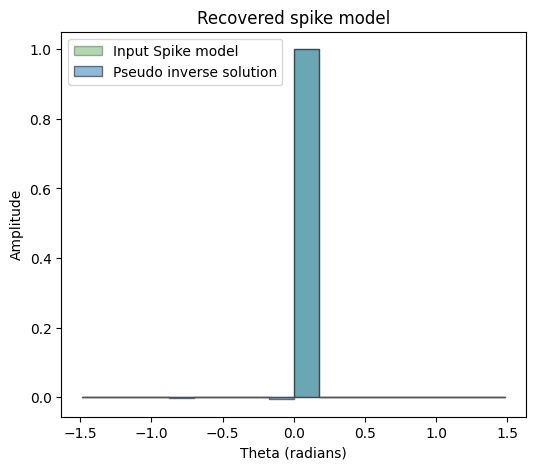

In [25]:
fig, ax = plt.subplots(figsize=(6,5))
plt.fill_between(spikeangles, spikemodel,step='mid',alpha=0.3,color='green',edgecolor='k',label='Input Spike model')
plt.fill_between(spikeangles, pseduo_sol,step='mid',alpha=0.5,edgecolor='k',label='Pseudo inverse solution')
plt.legend()
plt.title('Recovered spike model')
plt.xlabel('Theta (radians)')
plt.ylabel('Amplitude')
plt.show()

*The solution looks very close to the truth, and much better than the least squares version.*

**Task 5** Now add a very small amount of IID Gaussian random noise to the data with zero mean ${\cal N}(0,\sigma^2I_N)$ and plot the original data together with the noisy data. Choose $\sigma=10^{-6}$.

Is there any discernable difference between the noiseless and the noisy data?

In [29]:
sigma = 1.0E-6 # small standard deviation of noise.
spikedata_noisy = spikedata + np.random.multivariate_normal(np.zeros(n), (sigma**2)*np.eye(n))

Now plot the noisy and perfect data together.

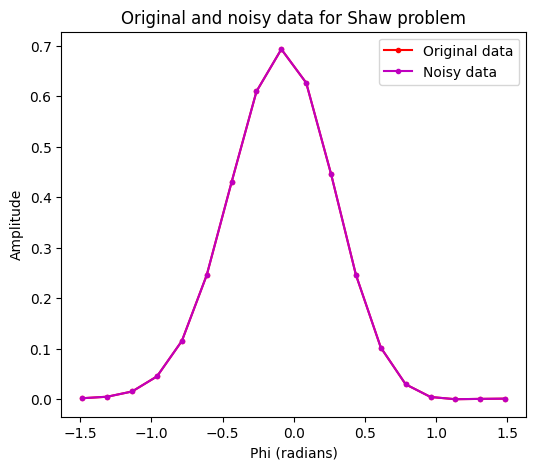

In [33]:
fig, ax = plt.subplots(figsize=(6,5))
plt.plot(spikeangles,spikedata,'r.-',label='Original data')
plt.plot(spikeangles,spikedata_noisy,'m.-',label='Noisy data')
plt.title('Original and noisy data for Shaw problem')
plt.xlabel('Phi (radians)')
plt.legend()
plt.ylabel('Amplitude')
plt.show()

*The curves overlap each other and are indistinguishable to the eye. The differences between the noisy data and the original data are too small to see on this plot.*

**Task 6** Now calculate the solution using the pseudo inverse solution for the noisy data. What do you notice?

In [34]:
pseduo_sol_noisy =  Gdagger @ spikedata_noisy # pseudo inverse solution

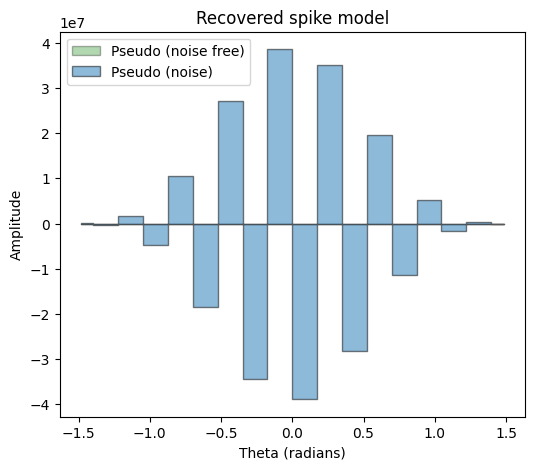

In [36]:
fig, ax = plt.subplots(figsize=(6,5))
plt.fill_between(spikeangles, pseduo_sol,step='mid',color='g',alpha=0.3,edgecolor='k',label='Pseudo (noise free)')
plt.fill_between(spikeangles, pseduo_sol_noisy,step='mid',alpha=0.5,edgecolor='k',label='Pseudo (noise)')
plt.legend(loc=2)
plt.title('Recovered spike model')
plt.xlabel('Theta (radians)')
plt.ylabel('Amplitude')
plt.show()

*Looks nothing like the original. A small amount of noise has caused enormous changes in the solution. Even though the $G$ matrix is full rank, it is still ill-posed where small errors in the data amplify to large errors in the solution.*

**Task 7** To see where this shape comes from plot the singular vector for the smallest singular value included in the solution. This would be the 18th singular vector, or the 18th column of the matrix $V$.

In [37]:
u,s,vt = np.linalg.svd(G) # singular value decomposition 
Vp = vt.T

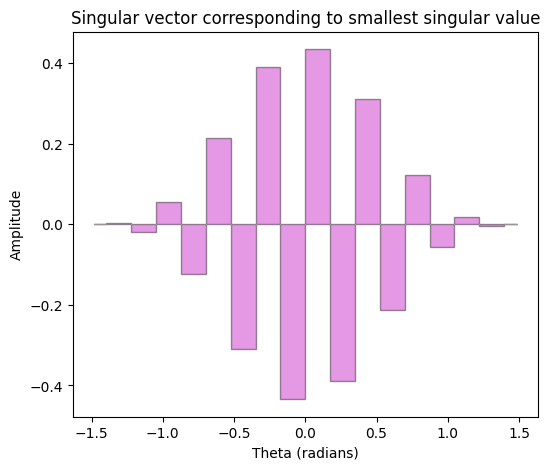

In [38]:
fig, ax = plt.subplots(figsize=(6,5))
plt.fill_between(spikeangles, Vp[:,-1],step='mid',alpha=0.4,color='m',edgecolor='k',label='Pseudo (noise)')
plt.title('Singular vector corresponding to smallest singular value')
plt.xlabel('Theta (radians)')
plt.ylabel('Amplitude')
plt.show()

*This looks identical to the pseudo solution except its vertical scale is similar to that of the model. This tells us that the pseudo solution for noisy data is dominated by the singular vector for the smallest singular value.*

**Task 8** Now plot singular vectors for the 1st, 5th, 11th and 18th singular values.

We now plot all singular vectors and exaime them.

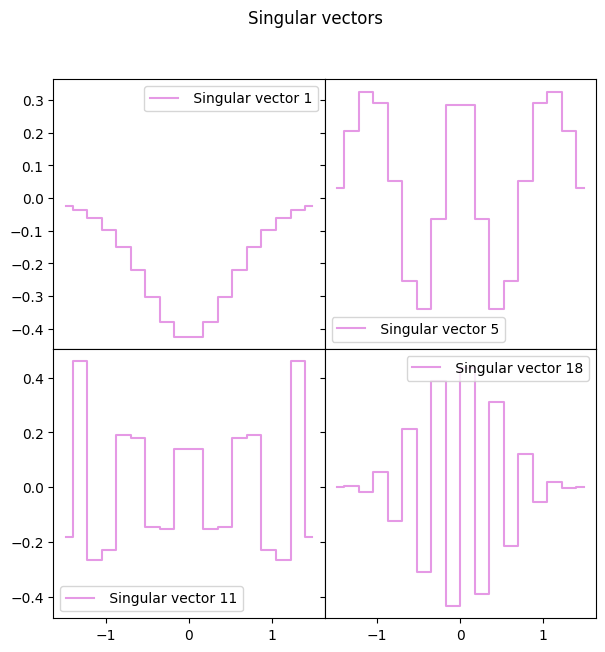

In [41]:
plist = [1,5,11,18]
fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(2,2, hspace=0, wspace=0)
ax = gs.subplots(sharex='col', sharey='row')
fig.suptitle('Singular vectors')
fill = False
k=0
for i in range(2):
    for j in range(2):
        if(fill):
            ax[i,j].fill_between(spikeangles, -Vp[:,plist[k]-1],step='mid',alpha=0.4,color='m',edgecolor='k',label=' Singular vector '+str(plist[k]))
        else:
            ax[i,j].step(spikeangles, Vp[:,plist[k]-1],where='mid',alpha=0.4,color='m',label=' Singular vector '+str(plist[k]))
        ax[i,j].legend()
        k+=1

*This has the same shape as the recovered solution. It indicates that Pseudo inverse solution using all 18 singular values is a scalled version of the corresponding singular vector.* 

**Task 9** Find a $p$ value for which you judge the pseudo inverse solution best recovers the true spike model. By reducing the maximum number of singular values in the solution,  what have you managed to do to the inverse problem? What has been sacrificed to achieve this?

In [42]:
# loop over p values
solp,Gdag = [],[]
for i in range(18):
    Gdag.append(pseudo_inverse(G,i+1))
    solp.append(Gdag[i] @ spikedata_noisy) # pseudo inverse solution for this number of singular values

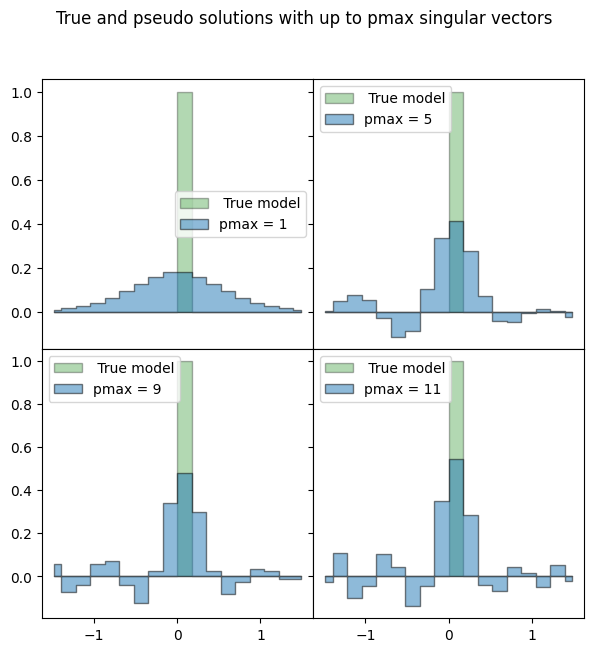

In [43]:
plist = [1,5,9,11]
fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(2,2, hspace=0, wspace=0)
ax = gs.subplots(sharex='col', sharey='row')
fig.suptitle('True and pseudo solutions with up to pmax singular vectors')
fill = True
k=0
for i in range(2):
    for j in range(2):
        psol = plist[k]-1
        if(fill):
            ax[i,j].fill_between(spikeangles, spikemodel,step='mid',alpha=0.3,color='g',edgecolor='k',label=' True model')
            ax[i,j].fill_between(spikeangles, solp[psol],step='mid',alpha=0.5,edgecolor='k',label='pmax = '+str(1+psol))
        else:
            ax[i,j].step(spikeangles, Vp[:,plist[k]-1],where='mid',alpha=0.4,color='m',label=' Singular vector '+str(plist[k]))
        ax[i,j].legend()
        k+=1

*As p decreases from 18 to 1 the amplitude decreases to a best fit around 9 or 10 and the averaging width decreases. I choose a p=11 as optimal, but this is subjective.*

In [131]:
popt = 11

#### Uncertainty in the pseudo solution

The model covariance matrix for the pseudo inverse is given by

$$
C_M = G^{\dagger} C_D (G^{\dagger})^T =  \sigma^2 G^{\dagger} (G^{\dagger})^T = \sigma^2 V_p S^{-2} V_p^T
$$


**Task 10** Calculate the model covariance matrix for your chosen value of $p$ and plot the 95% confidence intervals for each parameter as upper and lower bounds about your chosen solution. Note that the 95% confidence interval about the $i$th model parameter value is given by $\pm 1.96*[(C_M)_{i,i}]^{1/2}$, i.e. the square root of the corresponding diagonal element of $C_M$.



How do these error bars compare to the distance between your estimated and true spike model solution?

In [132]:
Cm = (sigma**2)*Gdag[popt-1] @ Gdag[popt-1].T # model covariance matrix
error = 1.96*np.sqrt(np.diag(Cm)) # standard deviations on each model parameter

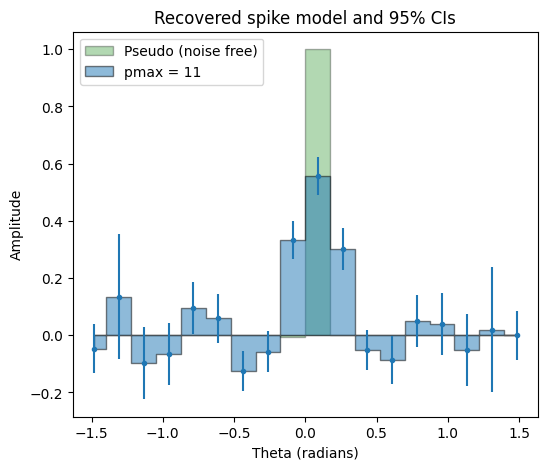

In [136]:
fig, ax = plt.subplots(figsize=(6,5))
plt.fill_between(spikeangles, pseduo_sol,step='mid',color='g',alpha=0.3,edgecolor='k',label='Pseudo (noise free)')
plt.fill_between(spikeangles, solp[popt-1],step='mid',alpha=0.5,edgecolor='k',label='pmax = '+str(popt))
plt.errorbar(spikeangles, solp[popt-1], yerr=error, fmt='.')
plt.legend(loc=2)
plt.title('Recovered spike model and 95% CIs')
plt.xlabel('Theta (radians)')
plt.ylabel('Amplitude')
plt.show()

*I notice that for $p_{max} = 11$ the $95\%$ confidence intervals do not contain the true model. This is because the regularized solution is biased as noise propagation from data is supressed.*
